In [3]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read();return HTML(styles)
css_styling()


<figure>
<IMG SRC="./images/PhysicsLogo.jpg" WIDTH=100 ALIGN="right">
</figure>

# [Physics 411](http://jklymak.github.io/Phy411/) Time Series Analysis
*Jody Klymak*


# Week 6: Linear Systems and Coherence

<figure>
<IMG SRC="./images/ExampleSpectra1.png" WIDTH=220 ALIGN="right" STYLE="padding-left:20px" ALT="Turbulence and internal wave spectra in the ocean">
</figure>

Power spectra are helpful to characterize a time series in terms of its frequency content.  We can use the same concepts to characterize the linear relationship between two time series in terms of their frequency content.  

As a motivating example, turbulence in the atmosphere is often measured using [pitot tubes](http://en.wikipedia.org/wiki/Pitot_tube) on the nose of the airplane, which works well, except the airplane is often also vibrating.  We do a similar thing in the ocean, where we have an airfoil probe that characterizes the turbulence, but there are vibrations in the body.  

An example of a turbulent spectrum from an underwater vehicle is seen to the right, using the thin black curve.  The gray curve is the output from an accelerometer on the vehicle.  You can see that these spectra have peaks in common.  Therefore it might be relevant to compute the degree of correlation as a function of frequency.  

In fact, we want to *remove* as best we can the effect of the vibrations from the spectrum of the turbulence.  In the plot to the right, that has been done with the thick black line.  The smooth curve is a fit to a known curve for turbulence.  

Of course, this procedure only works if the system is *linear*, so that the output depends proportionally on the input.  Fortunately that is often the case.  

## Linear systems

First lets discuss linear systems, in which the input to the system $F(t)$ (or the forcing) uniquely describes the output $y(t)$, i.e. $y(t)=\mathcal{L}(F(t))$.  The system is **Linear** if the response of the system can be described by the convolution of the input with the *impulse response function*:
    $$h(t)=\mathcal{L}(\delta(t))$$

i.e. the system $\mathcal{L}$ is linear if 
\begin{align}
    y(t)&=h(t)\star F(t)\\
    &= \int_{-\infty}^{\infty} F(\tau)h(t-\tau)\ \mathrm{d}\tau
\end{align}
and $h(t)$ describes the response of $\mathcal{L}$ uniquely.  

#### Example

A simple example is a damped spring moving horizontally and subject to an external forcing $F(t)$ in the $y(t)$ direction.  Then the linear system is 
$$m \frac{d^2y}{dt^2} =  F(t) - c \frac{dy}{dt} - k y$$
Then we can solve for the impulse response function $h(t)$ by solving:
$$m \frac{d^2h}{dt^2} =  \delta(t) - c \frac{dh}{dt} - k h$$

This system has a natural frequency of $f_n = \frac{1}{2\pi}\sqrt{\frac{k}{m}}$ and the damping factor is $\zeta = \frac{c}{2}\frac{1}{\sqrt{k m}}$.  We choose a natural frequency of 1 Hz and a damping factor of 0.01, and then solve for the impulse response numerically. 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib nbagg

m = 1.
fn = 1.
damp = 0.01
k = (fn*2*np.pi)**2*m
c = damp*2*np.sqrt(k*m)
print 'damping = %2.2f' % damp
print 'fn = %2.2f Hz' % fn
print 'c = %2.2f kg s^-1' % c
print 'k = %2.2f kg s^-2' % k


damping = 0.01
fn = 1.00 Hz
c = 0.13 kg s^-1
k = 39.48 kg s^-2


Now lets code the linear system.  If we let $u_i$ be the velocity at time step $i$, etc, then its basically just:

$$x_i = x_{i-1} + \Delta t\  u_{i-1}$$ 
$$ u_i = u_{i-1} + \Delta t \left( F/m - (c/m) u_{i-1} - (k/m) x_{i-1} \right)$$ 

Note that we solve for $x_i$ first, and then solve for the new $u_i$.  If we don't, then there is a slight phase error.  

We'll assume the weight is at rest at the origin with no acceleration:

<IPython.core.display.Javascript object>


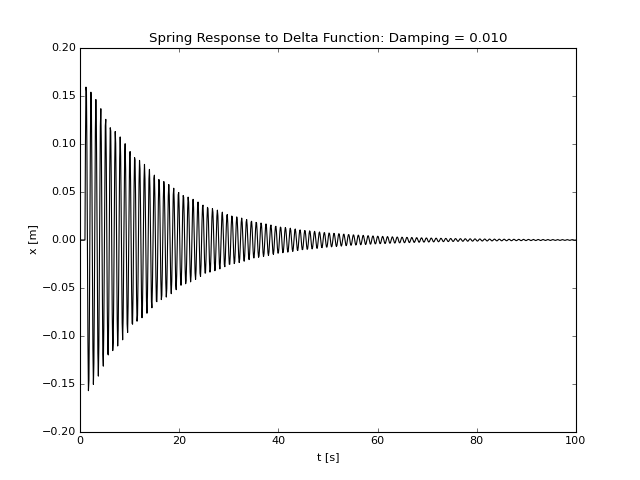

In [7]:
def spring(t,F,m,c,k):
    "Integrate the spring equation"
    u = F*0.
    x = F*0.
    x[0]=0.
    N = np.shape(t)[0]
    dt = np.median(np.diff(t))
    for i in range(1,N):
        x[i] = x[i-1]+dt*(u[i-1])
        u[i]= u[i-1] + dt*(F[i]/m - (c/m)*(u[i-1]) - (k/m)*(x[i]))
    return x,u
t = np.arange(0.,1000.,1000./10000.)
F=0*t
F[10]=10.;
x,u=spring(t,F,m,c,k)
fig,ax=plt.subplots()
ax.plot(t,x,'k')
ax.set_xlim((0,100))
ax.set_xlabel('t [s]')
ax.set_ylabel('x [m]')
ax.set_title('Spring Response to Delta Function: Damping = %1.3f' % damp)

Here we have the response we might expect to a sharp forcing of the system, and is a graphical representation of $h(t)$.  An arbitrary forcing $f(t)$ could be convolved with this response to get $x(t)$.

Now, recall that the Fourier transform of a convolution is a multiplication of the Fourier transforms:
$$ \mathcal{F}(F(t)\star h(t)) = \mathcal{F}(F(t))\, \mathcal{F}(h(t)),$$ or if we prefer power spectra
$$G_{xx}(f) = G_{FF}(f)G_{hh}(f)$$

This is nice, because if we know the Fourier transform of the impulse function, we know the sepctrum of any forcing by just multiplying the two.

#### Back to the Example####

Going back to the example, we can calculate the frequency response of the linear system.  We simply take the Fourier transform of 
$$ m h'' = \delta(t) - c h' -kh$$
Recall that 
if $X(f)$ is the Fourier transfrom of $x(t)$, then the inverse FT is:
$$ x(t) = \int_{-\infty}^{\infty} X(f)\mathrm{e}^{j2\pi ft}\ \mathrm{d}f$$
and 
$$ \frac{d x}{dt} = \int_{-\infty}^{\infty} j2\pi f  X(f)\mathrm{e}^{j2\pi ft}\ \mathrm{d}f$$
and
$$ \frac{d^2 x}{dt^2} =  \int_{-\infty}^{\infty} -(2\pi f)^2 X(f)\mathrm{e}^{j2\pi ft}\ \mathrm{d}f$$
So the FT of $dx/dt$ is $j\pi f X(f)$, and $d^2x/dt^2$ is $-4\pi^2f^2X(f)$, 
which for $h(t)$ yields
\begin{align}
    -(2\pi f)^2 m H(f)& = 1 - j c 2\pi f H(f) - k H(f)\\
\end{align}
or collecting terms:
\begin{align}
    H(f)=&\frac{1}{-(2\pi f)^2 m  +k + j2\pi fc}\\
        =&\frac{1/k}{1-\left(f/f_n\right)^2 + j 2\zeta\left(f/f_n\right)}
\end{align}
using our definitions of the damping factor $\zeta$ and the natural frequency $f_n$.

The absolute value of the response function gives us the amplitude amplification for a forcing at any given frequency:
$$ | H(f)| = \frac{1/k}{\left(\left(1-\left(f/f_n\right)^2\right)^2 + 4\zeta^2\left(f/f_n\right)^2\right)^{1/2}}$$
where we note that if $\zeta\to 0$, $|H(f)|$ has a sigularity at $f=f_n$, which is resonance.  This resonance is damped as $\zeta$ gets larger.  If $f\ll f_n$ then $H(f)\to 1$.

<IPython.core.display.Javascript object>


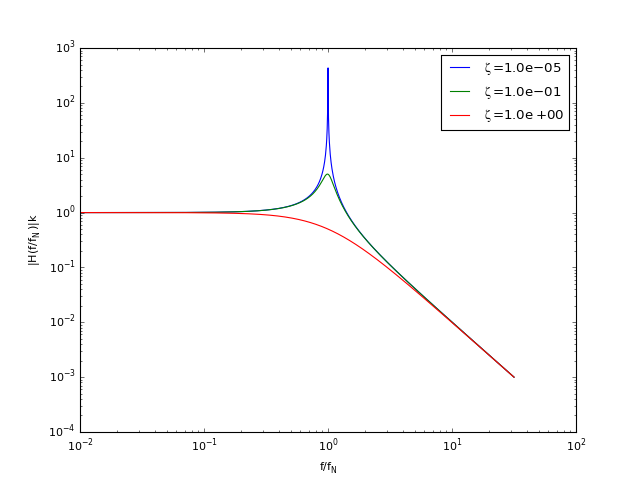

In [8]:
f=np.logspace(-2.,1.5,1000)
zeta = [0.00001,0.1,1.]
k=1.
fig,ax=plt.subplots(1,1)
for ind in range(len(zeta)):
    abH = (1./k)/np.sqrt((1-f**2)**2+4*zeta[ind]**2*f**2)
    ax.loglog(f,abH,label=r'$\zeta=%1.1e$'%zeta[ind]  )
ax.set_xlabel('$f/f_N$')
ax.set_ylabel('$|H(f/f_N)| k$')
ax.legend()

Hopefully this response makes sense: if we force at the natural frequency we get resonance.  If we force at a much lower frequency, we get back what we put in.  If we force "too fast" then the forcing works against the natural frequency and the response is damped.  This is a very natural way to think about the system.

So, lets just test, using our numerical spring system from above and forcing with three frequencies:

<IPython.core.display.Javascript object>


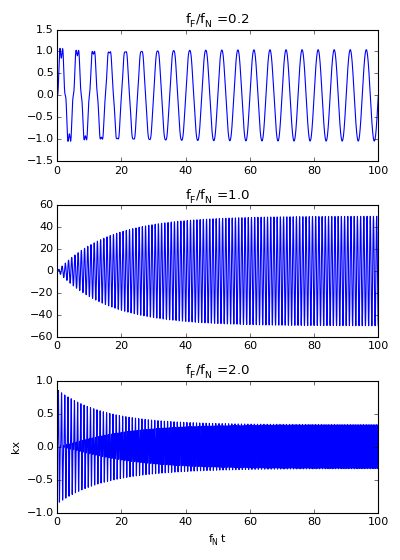

In [10]:
t = np.arange(0.,100.,1000./100000.)
F=0*t
m = 1.
fns = [0.2,1.,2.]
fn=1.
fig,axs=plt.subplots(3,1,figsize=(5,7))
for ind,fForce in enumerate(fns): 
    ax=axs[ind]
    damp = 0.01

    k = (fn*2.*np.pi)**2*m

    c = damp*2.*np.sqrt(k*m)
    
    F=np.sin(t*2*np.pi*fForce);
    x,u=spring(t,F,m,c,k)
    
    ax.plot(t,x*k)
    ax.set_title('$f_{F}/f_N = %1.1f$'%(fForce/fn))
ax.set_xlabel('$f_N t$ ')
ax.set_ylabel('kx')
plt.tight_layout()

### Phase response:

Note that there is also a phase shift associated with the damping because $H(f)$ is a complex function of $f$.  The phase shift is given by:
$$ \phi(f)=\mathrm{atan} \left[\frac{2\zeta(f/f_n)}{1+\left(f/f_n\right)^2} \right]$$
If $\zeta=0$ then there is no phase shift, but it is appreciable for non-zero $\zeta$.  For $f<f_N$ the phase shift is zero, and for $f\gg f_N$  it approaches $\pi$.

<IPython.core.display.Javascript object>


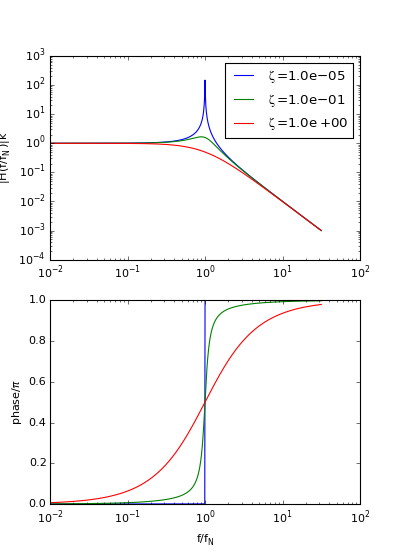

In [11]:
f=np.logspace(-2.,1.5,1000)
zeta = [0.00001,0.1,1.]
k=1.
fig,axs=plt.subplots(2,1,figsize=(5,7))

for ind in range(len(zeta)):
    abH = (1./k)/np.sqrt((1-f**2)**2+4*zeta[ind]*f**2)
    pha = np.arctan2(2*zeta[ind]*f,(1-f**2))
    axs[0].loglog(f,abH,label=r'$\zeta=%1.1e$'%zeta[ind]  )
    axs[1].semilogx(f,pha/np.pi,label=r'$\zeta=%1.1e$'%zeta[ind]  )
axs[1].set_xlabel('$f/f_N$')
axs[0].set_ylabel('$|H(f/f_N)| k$')
axs[1].set_ylabel('$phase / \pi$')
axs[0].legend() 

<IPython.core.display.Javascript object>


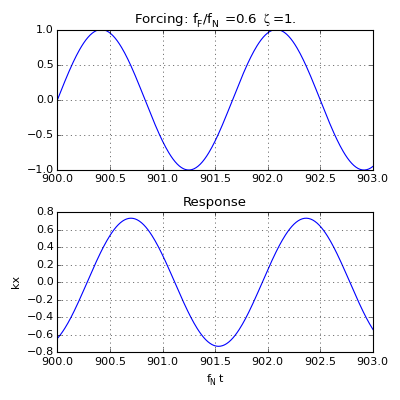

In [13]:
t = np.arange(0.,1000.,1000./100000.)
F=0*t
m = 1.
fns = [0.6]
fn=1.
fig,axs=plt.subplots(2,1,figsize=(5,5))
for ind,fForce in enumerate(fns): 
    ax=axs[1]
    damp = 1.
    k = (fn*2*np.pi)**2*m
    c = damp*2*np.sqrt(k*m)
    # forcing:
    F=np.sin(t*2*np.pi*fForce);
    x,u=spring(t,F,m,c,k)
    ax.plot(t,x*k)
    axs[0].set_title('Forcing: $f_{F}/f_N = %1.1f \ \ \zeta=1.$'%(fForce/fn))
ax.set_xlim(np.array([0,3])+900)
axs[0].plot(t,F);axs[0].set_xlim(np.array([0,3])+900);axs[0].xaxis.grid();axs[0].yaxis.grid()
axs[1].set_xlabel('$f_N t$ ');axs[1].set_ylabel('kx');axs[1].set_title('Response')
plt.grid();plt.tight_layout()

So here we can see that the response lags the forcing due to the damping (in this case $\zeta=1.0$).

### System identification

So we may know the forcing of our system $F(t)$, and we may know the output $x(t)$, but we may not know *a-priori* the character or the parameters of the system.  If there is no noise in the output $x(t)$, and we can assume the system is linear, then as we note above:
$$ X(f) = H(f)F(f)$$
where $F(f)$ is the Fourier transform of the forcing, $X(f)$ is the FT of the response, and $H(f)$ the impulse response function.  

First, its easy to note that:
$$G_{xx}(f)=|H(f)|^2G_{FF}(f)$$
where $G_{FF}(f)$ is the power spectrum of the forcing, and $G_{xx}$ is the power spectrum of the output.

If we want the phase information, we note that:
$$X(f)F^*(f)=H(f)F(f)F^{*}(f)$$
or:
$$H(f)=\frac{G_{xF}(f)}{G_{FF}(f)}$$
where $G_{xF}(f)$ is the co-spectrum between the forcing and response (recall this is a complex number).  The phase then is simply:
$$\phi(f)=\mathrm{atan}(\mathcal{I}(G_{xF})/\mathcal{R}(G_{xF}))$$


Lets go through these calculations for our spring system.  We will force with a broadband red process with a cosine at $f=f_N/2$:

<IPython.core.display.Javascript object>


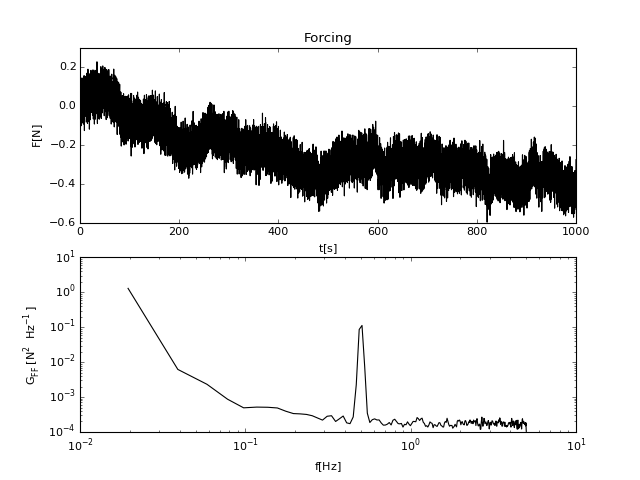

In [25]:
# set up and plot the forcing
N=10000

import matplotlib.mlab as mlab
# time vector
t = np.arange(0.,1000.,1000./N)
dt = np.median(np.diff(t))
# forcing
F = 0.003*np.cumsum(np.random.randn(N))+0.03*np.random.randn(N)+0.09*np.cos(2*np.pi*fn/2.*t)
# power spectrum of forcing
p,f=mlab.psd(F,NFFT=512,Fs=1./dt,window=mlab.window_hanning,noverlap=512/2);
# plot
fig,ax=plt.subplots(2,1)
ax[0].plot(t,F,'k')
ax[0].set_xlabel(r'$t \mathrm{[s]}$')
ax[0].set_ylabel(r'$F \mathrm{[N]}$')
ax[0].set_title(r'Forcing')
ax[1].loglog(f,p,'k')
ax[1].set_xlabel(r'$f \mathrm{[Hz]}$')
ax[1].set_ylabel(r'$G_{FF}\ \mathrm{[N^2\ Hz^{-1}]}$')

<IPython.core.display.Javascript object>


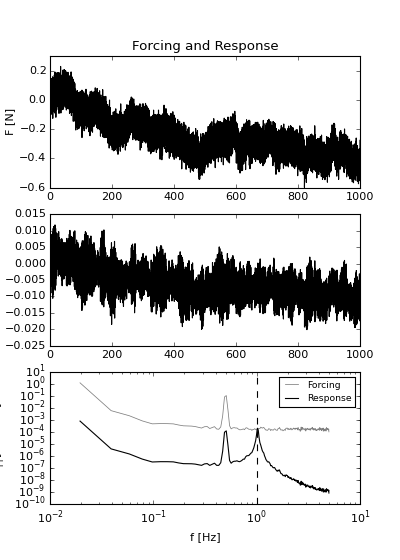

In [33]:
m = 1.
fn = 1.
damp = 0.01
k = (fn*2*np.pi)**2*m
c = damp*2*np.sqrt(k*m)
# get the spring's response from the numerical method above:
x,u=spring(t,F,m,c,k)
# get its power spectrum:
px,fx=mlab.psd(x,NFFT=512,Fs=1./dt,window=mlab.window_hanning,noverlap=512/2)
# plot
fig,axs=plt.subplots(3,1,figsize=(5,7))
axs[0].plot(t,F,'k')
axs[0].set_ylabel('F [N]')
axs[0].set_title('Forcing and Response')

axs[1].plot(t,x,'k')
axs[1].set_ylabel('x [m]');

axs[2].loglog(f,p,color="0.5",linewidth=0.7,label='Forcing')
axs[2].loglog(fx,px,'k',label='Response')
axs[2].plot(fn*np.ones(2),[1e-10,10],'k--')
axs[2].set_xlabel('f [Hz]')
axs[2].set_ylabel(r'$G_{FF} \mathrm{[N^2 Hz^{-1}]}$')
axs[2].legend(fontsize='small')

We see that the response looks like the forcing at low frequencies, rolls off at high frequencies, and has a resonance at the resonant peak, 1 Hz.  Now we can compare the two spectra to see if the gain factor and phase agree with the predictions from above.


<IPython.core.display.Javascript object>


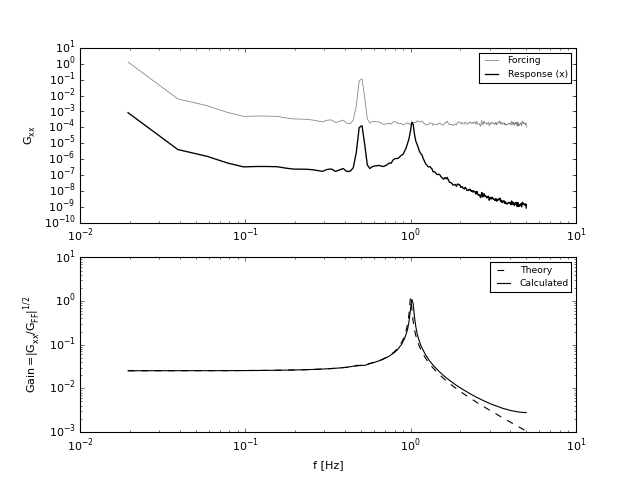

In [38]:
def springresp(f,m,c,k):
    "Get the response function at frequencies f"
    fn = np.sqrt(k/m)/2./np.pi
    zeta = c/2./np.sqrt(k*m)
    f = f/fn
    H = (1./k)/(1-f**2 + 2.j*zeta*f)
    return H
fig,axs=plt.subplots(2,1)
axs[0].loglog(f,p,'k',color="0.5",linewidth=0.7,label='Forcing')
axs[0].loglog(f,px,'k',linewidth=1.2,label='Response (x)')
axs[0].set_ylabel(r'$G_{xx}$')
axs[0].legend(fontsize='small')
H = springresp(f,m,c,k)
# theoretical response
axs[1].loglog(f,abs(H),'k--',label='Theory')
# this is the response function.
axs[1].loglog(f,np.sqrt(px/p),'k',label='Calculated')
axs[1].set_xlabel('f [Hz]');
axs[1].set_ylabel(r'$Gain = |G_{xx}/G_{FF}|^{1/2}$')
axs[1].legend(fontsize='small')

In order to get the phase response $\phi(f)$, we use `mlab.csd` which is the direct analogue to `mlab.psd` to calculate $G_{xF}(f)$:

<IPython.core.display.Javascript object>


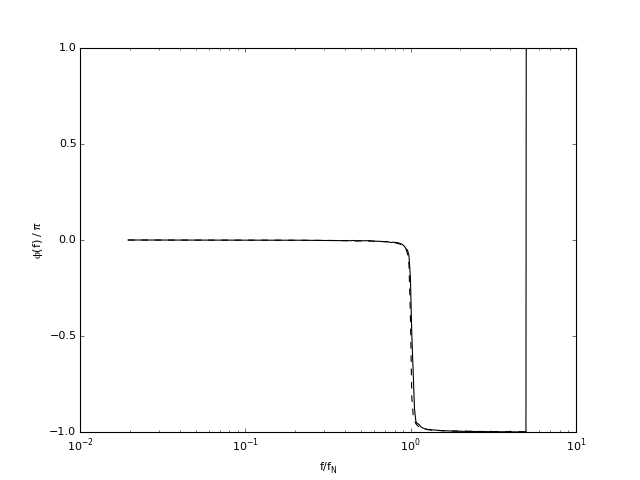

In [40]:
cFx,f=mlab.csd(F,x,NFFT=512,Fs=1./dt,window=mlab.window_hanning,noverlap=512/2)
ang = np.arctan2(np.imag(cFx),np.real(cFx))
angTh = np.arctan2(np.imag(H),np.real(H))
fig,ax=plt.subplots(1,1)
ax.semilogx(f,ang/np.pi,'k')
ax.semilogx(f,angTh/np.pi,'k--')
ax.set_xlabel('$f/f_N$')
ax.set_ylabel('$\phi(f)\ /\ \pi$')

So our modelled scenario has the same phase shift as the theoretical response: in phase below the natural frequency, and $\pi$ out of phase above.  

## Coherence

Finally, suppose out system has some noise $n(t)$ in the measurment of the output:
$$ x(t) = n(t)+\mathcal{L}(F(t))$$
We might suspect that the noise will make the output, $x(t)$, less coherent with the input $F(t)$ if the noise is large.  If we take the Fourier transforms we get:
$$X(f) = N(f) + H(f)F(f)$$
and then consider the quantity:
$$\gamma^2(f) \equiv \frac{|G_{xF}(f)|^2}{G_{xx}G_{FF}}.$$
This is called the **Coherence Squared** between $x(t)$ and $F(t)$, and is closely related to the lag covariance function $C_{xy}(\tau)$.

First its worth noting that this is a statistical function.  If $G_{xF}$ etc are not computed with some averaging then we get the nonsensical result that:
$$\gamma^2(f) = \frac{XF^*FX^*}{XX^*FF^*}=1$$
However if we average (i.e. by block averaging as in the last lecture) denoted by angled brackets then:
$$\gamma^2(f) = \frac{\left<XF^*\right>\left<FX^*\right>}{\left<XX^*\right>\left<FF^*\right>}\leq 1$$
because we cannot take the Fourier transforms outside of the averaging brackets.  

Note that if $N(f)=0$, then we do get $\gamma^2=1$:
\begin{align}
    \gamma^2(f) =& \frac{\left<XF^*\right>\left<FX^*\right>}{\left<XX^*\right>\left<FF^*\right>}\\
    =& \frac{\left< HFF^* \right>\left<F(HF)^*\right>}{\left<HF(HF)^*\right>\left<FF^*\right>}\\   
    =& \frac{H\left<FF^* \right>H^*\left<FF^*\right>}{HH^*\left<FF^*\right>\left<FF^*\right>}\\  
    =& 1
\end{align}
because $H(f)$ is the same for all the averaging blocks.  If $|N(f)|>0$ then $\gamma^2<0$.

#### Example again:####

We calculated $G_{Fx}(f)$ above for a system with no noise, so we can plot the coherence squared:

<IPython.core.display.Javascript object>


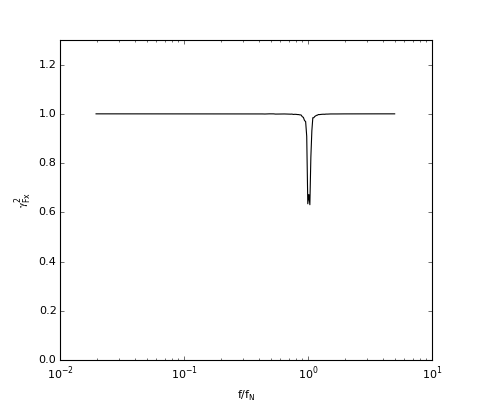

In [46]:
fig,ax=plt.subplots(1,1,figsize=(6,5))
ax.semilogx(f,abs(cFx)**2/p/px,'k')
ax.set_ylim([0.,1.3])
ax.set_ylabel('$\gamma^2_{Fx}$')
ax.set_xlabel('$f/f_N$')

And we can see that the coherence squared is indeed unity, except right at the peak, which is close to resonance.  This is probably a slight numerical error in our code.  

#### Example with noise ####

More elucidating is an example that uses noise.  Here is the noise, added to the *output*:

<IPython.core.display.Javascript object>


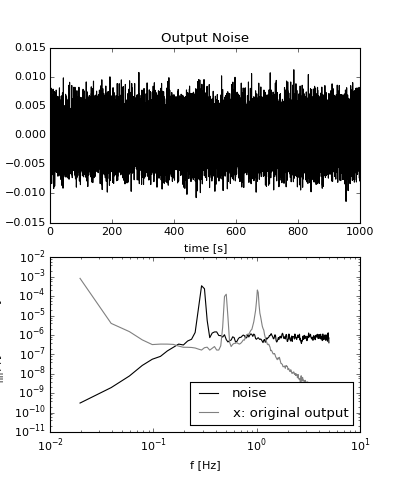

In [55]:
n = np.random.randn(N)
n = n-np.convolve(n,np.ones(40)/40.,'same')
n = n/500. + np.cos(t*2*np.pi*0.3)/200.

pn,fn=mlab.psd(n,NFFT=512,Fs=1./dt)
fig,ax=plt.subplots(2,1,figsize=(5,6))
ax[0].plot(t,n,'k')
ax[0].set_xlabel('time [s]');
ax[0].set_ylabel('Noise [m]');
ax[0].set_title('Output Noise')

ax[1].loglog(fn,pn,'k',label='noise')
ax[1].loglog(fx,px,color="0.5",label='x: original output')
ax[1].set_xlabel('f [Hz]');
ax[1].set_ylabel(r'$G_{nn}(f) \mathrm{[m^2\ Hz^{-1}]}$');
ax[1].legend(loc=4)

The noise spectrum is higher than the output at high frequencies, but lower at low frequencies, with a peak.  Now lets calculate the co-spectrum and $\gamma^2$:

<IPython.core.display.Javascript object>


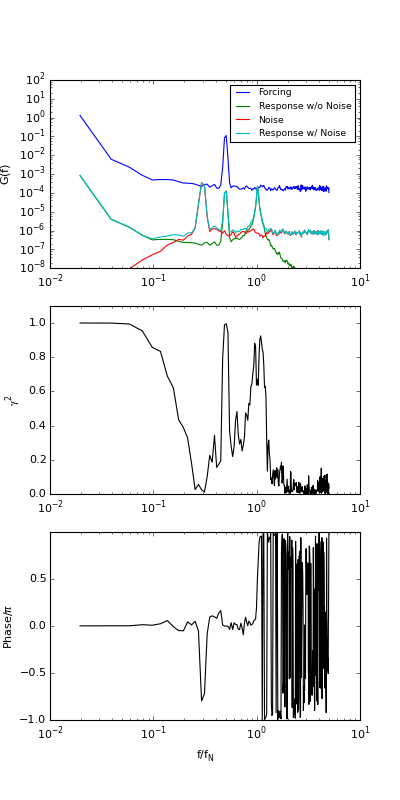

In [63]:
xn = x+n

cFxn,f=mlab.csd(xn,F,NFFT=512,Fs=1./dt,window=mlab.window_hanning,noverlap=256)
pxn,fxn=mlab.psd(xn,NFFT=512,Fs=1./dt,window=mlab.window_hanning,noverlap=256)
pF,fxn=mlab.psd(F,NFFT=512,Fs=1./dt,window=mlab.window_hanning,noverlap=256)
pn,fxn=mlab.psd(n,NFFT=512,Fs=1./dt,window=mlab.window_hanning,noverlap=256)
px,fxn=mlab.psd(x,NFFT=512,Fs=1./dt,window=mlab.window_hanning,noverlap=256)

fig,axs=plt.subplots(3,1,figsize=(5,10))
axs[0].loglog(f,pF,label='Forcing')
axs[0].loglog(f,px,label='Response w/o Noise')
axs[0].loglog(f,pn,label='Noise')
axs[0].loglog(f,pxn,label='Response w/ Noise')
axs[0].set_ylim((1e-8,100.))
axs[0].set_ylabel(r'$G(f)$')
axs[0].legend(loc=0,fontsize='small')

axs[1].semilogx(f,abs(cFxn)**2/pF/pxn,'k')
axs[1].set_ylim((0,1.1))
axs[1].set_ylabel(r'$\gamma^2$')

ang = np.angle(cFxn)
axs[2].semilogx(f,ang/np.pi,'k')
axs[2].set_yticks(np.arange(-1,1,0.5))
axs[2].set_ylabel('$Phase / \pi$')
axs[2].set_xlabel('$f / f_N$')
#text(2e-2,150,'phase lag between forcing and response with noise')
#ylim((-200,200))

So, there is a fair bit in this plot.  First, the Forcing is in blue $G_{FF}$ in the upper plot.  The response without the noise is in green and has the peak at the forcing peak and at the resonant frequency.  If we add the noise to this signal (red), it swamps the output, *except* at the peaks (both the forcing peak and the resonant peak) and at low frequencies, where the noise has less amplitude.  

The coherence squared between the noise output and the forcing (second panel) tells us this story.  At low frequencies the input and output are coherent, as thet are at the forcing and resonant frequencies. Between the two peaks there is some coherence, and that makes sense because the noise (red curve) has a similar amplitude to the "clean" response (green curve) at those frequencies.  

The phase plot is a bit more confusing.  Simply the phase is as we'd expect it to be for the coherent part of the signals, and jumps around a lot when the signals are incoherent.  

### Determining $H(f)$

We can calculate $H(f)$ using the above information so long as noise doesn't swamp our signal too much.  Again
$$X(f)=N(f)+H(f)F(f)$$ so we can multiply both sides by $F^*(f)$ and get:
$$G_{xF}(f) = G_{NF}(f) + H(f)G_{FF}(f)$$
but if $n(t)$ is uncorrelated with the forcing $F(t)$ then we expect, on average
$G_{NF}(f)=0$ so an estiamte of $H(f)$ is:
$$\tilde{H}(f)=\frac{\left<  G_{xF}(f)\right>}{\left< G_{FF}(f) \right>}$$

Testing that on our example:

<IPython.core.display.Javascript object>


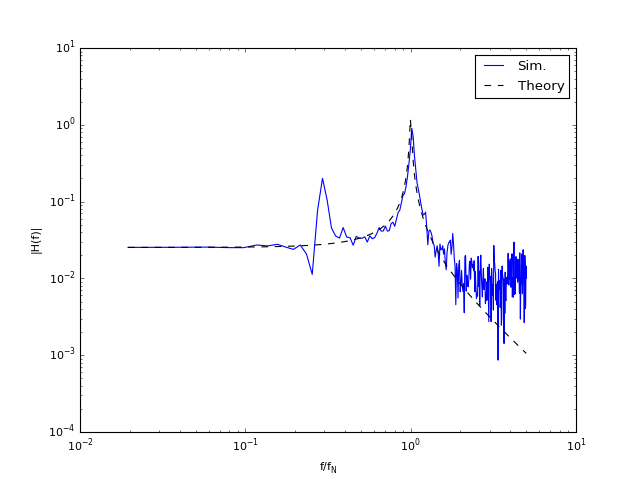

In [64]:
H = cFxn/pF
fig,ax=plt.subplots(1,1)
ax.loglog(f,abs(H),label='Sim.')
H = springresp(f,m,c,k)
# theoretical response
ax.loglog(f,abs(H),'k--',label='Theory')
ax.set_ylabel('|H(f)|')
ax.set_xlabel('$f/f_N$')
ax.legend()

So, we see that the estimate of the response is reasonable, though the noise spike at $f/f_N=0.3$ overwhelms the signal and puts a spurious response at that frequency.  Similarly the high wavenumbers are dominated by noise, so we cannot fit $H(f)$ very well at those frequencies.  This correlates well with the coherence squared estimate above that has low coherence at these frequencies.

Lets consider the related problem of isolating the *incoherent* part of the spectrum from the linear system.  Again, $$ x(t) = n(t)+\mathcal{L}(F(t))$$ and we measure $x(t)$ and $F(t)$ but we would like to know what the spectrum of $n(t)$ is.  This is the problem we were faced with for the turbulence measured from the vibrating vehicle: we could measure the forcing (or some of it), and wanted to remove it's effect from the measurement to get the residual.  Doing this to get $n(t)$ directly is almost impossible, but doing it statistically using the spectra is applying the same ideas as above.

Again, taking the Fourier Transform we get:
$$X(f)=N(f)+H(f)F(f)$$
and squaring both sides:
\begin{align}
    XX^*&=NN^*+HH^* FF^* + 2(NHF)(NHF)^*\\
    XX^*&=NN^*+HH^* FF^*\\
\end{align}
where we drop the last term because $N(f)$ is independent of $F(f)$.  If we replace $H(f)=\tilde{H}(f)=\frac{\left<  G_{xF}(f)\right>}{\left< G_{FF}(f) \right>}$ we can write:
\begin{align}
    \left<G_{NN}\left(f\right)\right>=\left<G_{xx}\left(f\right)\right>-\frac{\left| \left<G_{Fx}\left(f\right)\right> \right|^2}{\left<G_{FF}\left(f\right)\right>}\\
\end{align}

So, again testing on our simulated time series.  First, lets remind ourselves what we have.  

<IPython.core.display.Javascript object>


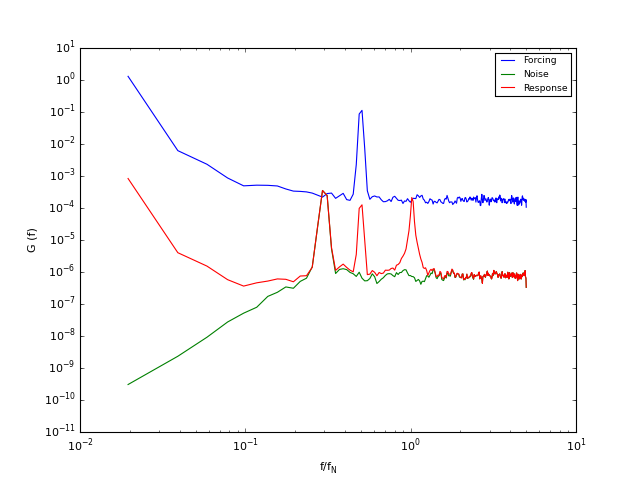

(<matplotlib.figure.Figure at 0x11e7b8850>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11b0eb350>)

In [67]:
def plotit():
    fig,ax=plt.subplots(1,1)
    ax.loglog(f,pF,label='Forcing')
    ax.loglog(f,pn,label='Noise')
    ax.loglog(f,pxn,label='Response')
    ax.legend(fontsize='small')
    ax.set_xlabel('$f/f_N$')
    ax.set_ylabel('G (f)')
    return fig,ax
plotit()

So, the "response" (red-coloured line) has a strong  peak at $f/f_N= 0.5$ due to the forcing, a peak from the noise (at $f/f_N= 0.3$), and a peak due to the resonance at $f/f_N=1.$. We would like to recover the "Noise" spectrum (green line) from the "Response" spectrum (red line).

<IPython.core.display.Javascript object>


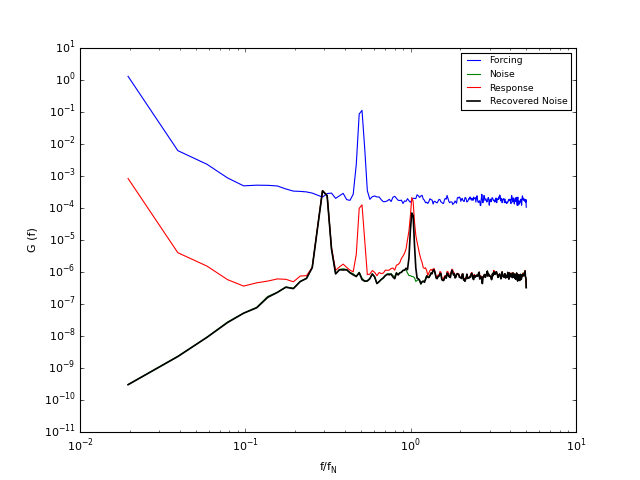

In [69]:
fig,ax=plotit()
Gnn =  pxn-abs(cFxn)**2/pF
ax.loglog(f,Gnn,'k',linewidth=1.5,label='Recovered Noise')
ax.legend(fontsize='small')


So, how did we do?  Pretty well for most of the spectrum (thick black line compared to green line), except for the very egregious peak at $f/f_N=1.0$ due to the resonance of the linear system.  It makes sense that this would be hard to get rid of: $F(t)$ doesn't contain any information about this resonance, so the response doesn't track it very well.  There may also be some effect of the numerics we used not keeping the forcing and response exactly in phase with each other.  Needless to say, removing a peak that is three orders of magnitude above the signal we want to see is a tall order.

For the rest of the spectrum, the procedure works very well, including at the peak due to the forcing at $f/f_N=0.5$.  

Of course in real life there would be some error in our measurement of the forcing $F(t)$, so such a nice correction of the spectrum is usually hard to achieve, but the procedure is quite useful for a number of systems. 